# Saliency and Class Activation Map Visualization using PyTorch & ResNet

Deep neural networks are powerful, but they can often behave like "black boxes":  
You input an image and get a prediction—but how does the model decide what it sees?

**Saliency maps** and **Grad-CAM (Gradient-weighted Class Activation Mapping)** are two powerful visualization techniques that help you "peek inside" a model's decision process. 
They allow you to see which areas or pixels in an image matter most to the network for a particular prediction.

In this notebook, you will:

- Load and preprocess images for a pre-trained ResNet model.
- Perform predictions and retrieve class probabilities.
- Compute **saliency maps** by backpropagating gradients from the target class all the way to the input pixels.
- Compute **class activation ("attention") maps** (GradCAM) to see what spatial regions influenced the model's choice.
- Overlay these visualizations on top of the original images to interpret the model's focus.
- Understand the intuition and math behind each visualization, with step-by-step code explanations.

Let's get started!

## 1 - Importing the libraries

In [1]:
import os

import cv2
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

from skimage.transform import resize
import torch
import torch.nn as nn
import torchvision.models as tv_models
import torchvision.transforms as transforms

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## 2 - Loading the Pretrained ResNet50 and Class Labels

### 2.1 Load the Pretrained ResNet50 Model

You will use ResNet50, a powerful convolutional neural network trained on the [ImageNet](https://www.image-net.org/) dataset (1000 classes).

Saliency maps can be computed for any image classifier, but ImageNet models are popular for demos.

*You should also fetch the class label names for making your outputs human-readable.*

In [2]:
# Load pretrained ResNet50 model and class labels from local cache
import os
torch.hub.set_dir(os.path.join(os.getcwd(), 'pretrained_model'))
model = tv_models.resnet50(weights=tv_models.ResNet50_Weights.IMAGENET1K_V1)
model.eval()
model.to(device)

# Class names
imagenet_class_mapping = tv_models.ResNet50_Weights.IMAGENET1K_V1.meta["categories"]
print(f"Loaded {len(imagenet_class_mapping)} classes.")

Loaded 1000 classes.


### 2.2 Image Preprocessing

ResNet50 expects:

- Images as RGB, shape (224, 224)
- Pixel normalization using ImageNet statistics:  
  Mean = [0.485, 0.456, 0.406], Std = [0.229, 0.224, 0.225]

Here's how you process an image from file to tensor:

In [3]:
# Image preprocessing transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def load_image(img_path):
    img = Image.open(img_path)
    if img.mode != 'RGB':
        img = img.convert('RGB')
    return img

### 2.3 Prediction and Visualizing Inputs

### Load an Image and Make a Prediction

Let's load an image, transform it, and get the model's top prediction.

You can use your own images or try the examples below (place them in an `images/` folder):

Predicted class: Labrador retriever (prob: 0.458)


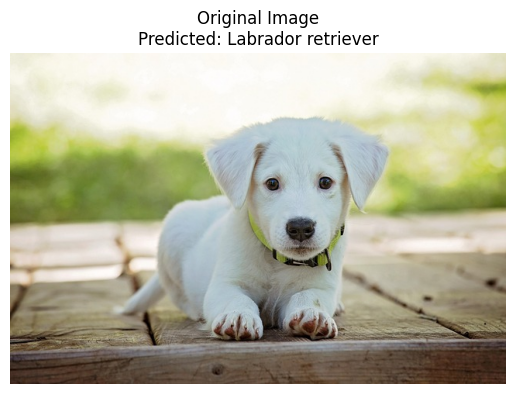

In [4]:
img_path = 'images/dog.jpg'  # Change to your own image path

if not os.path.exists(img_path):
    raise FileNotFoundError("Please provide a valid path to an image.")

img_pil = load_image(img_path)
img_tensor = transform(img_pil).unsqueeze(0).to(device)

# Forward pass
with torch.no_grad():
    logits = model(img_tensor)
    probs = torch.softmax(logits, dim=1)
    pred_prob, pred_class = torch.max(probs, dim=1)
    pred_label = imagenet_class_mapping[pred_class]
print(f"Predicted class: {pred_label} (prob: {pred_prob.item():.3f})")

# Show the image
plt.imshow(np.array(img_pil))
plt.title(f"Original Image\nPredicted: {pred_label}")
plt.axis('off')
plt.show()

## 3 - Saliency Maps 

### 3.1 A bit of theory

When you use a deep neural network to classify images, it is often helpful to "see what the model is looking at."  
A **saliency map** helps you visualize which parts of an image are most important for your model's decision.  
- Think of it as a heatmap, where "hot" pixels strongly influence the prediction.

How does this work?
- Think about how your model would "feel" a change in each pixel: "If I change this pixel, does my prediction go up or down?"
- The **saliency map** answers this: it measures, for each input pixel, how much changing that pixel would change the score for the target class.

<details>
<summary><strong>Show mathematical details</strong></summary>
<br>

For an input image $x$ and model output $f(x)$,  
if you are interested in class $c$, you compute:
\[
S_{i, j} = \left| \frac{\partial f_c(x)}{\partial x_{i, j}} \right|
\]
Where:
- $f_c(x)$: The model's score (before softmax) for class $c$.
- $x_{i, j}$: Pixel value at position $(i, j)$ of the input image.

**In practice**:  
- You compute the gradient of the output for class $c$ with respect to each pixel in the input image.
- You take the absolute value, and (usually) sum across color channels.
- This gives you a single heatmap that shows which pixels most affect the prediction for class $c$.

</details>

In [5]:
def compute_saliency_map(model, input_image, target_class=None):
    """
    Compute a saliency map for the input image using gradients of the model's output
    with respect to the input pixels.

    Args:
        model: PyTorch model (image classifier)
        input_image: Input tensor with shape [1, 3, H, W]. This will be cloned for gradient computation.
        target_class: Target class index. If None, uses the model's top predicted class.

    Returns:
        saliency_map: Numpy array (H, W). Each value represents the importance of that pixel.
        pred_class: Integer index of the class used for saliency (either given or predicted).
        pred_prob: Probability (float) assigned to that class.
    """
    # Ensure input_image is a leaf tensor (not from any computation graph) and enable gradient tracking
    input_image = input_image.clone().detach()
    input_image.requires_grad_()

    # Forward pass: get output logits from model
    output = model(input_image)  # shape: [1, num_classes]

    # Determine the class to use for saliency: use target_class if given, else model's prediction
    probs = torch.softmax(output, dim=1)
    if target_class is None:
        pred_prob, pred_class = torch.max(probs, dim=1)
        target_class = pred_class.item()
        pred_prob = pred_prob.item()
    else:
        pred_prob = probs[0, target_class].item()
        pred_class = target_class

    # Set all model gradients to zero for safety
    model.zero_grad()

    # Backward pass: compute gradient of output for target class w.r.t. input pixels
    # output is [1, num_classes], take value for [0, target_class]
    output[0, target_class].backward()

    # input_image.grad now contains the gradient of the target class score with respect to every input pixel
    gradients = input_image.grad.data[0]  # gradients shape: [3, H, W]

    # Common practice: take the sum of absolute gradients across the color channels to form a 2D map
    saliency_map = torch.abs(gradients).sum(dim=0).cpu().numpy()

    # Normalize to [0, 1] for visualization
    saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min() + 1e-8)

    return saliency_map, pred_class, pred_prob

In [6]:
saliency_map, pred_class, pred_prob = compute_saliency_map(model, img_tensor)
print("saliency_map shape:", saliency_map.shape)
print("pred_class:", pred_class)
print("pred_prob:", pred_prob)
print("Class label:", imagenet_class_mapping[pred_class])

saliency_map shape: (224, 224)
pred_class: tensor([208], device='cuda:0')
pred_prob: 0.4581267237663269
Class label: Labrador retriever


### 3.2 Compute and Visualize the Saliency Map

You will now compute the map and overlay it on the original image.

In [7]:
def visualize_saliency(img_display, saliency_map, pred_class, pred_score, title):
    """
    Display the original image, the (optionally enhanced) saliency map, and an overlay of both.
    Args:
        img_display: Original image as a numpy array (H, W, 3), not normalized (uint8, 0-255).
        saliency_map: Computed saliency array (usually 224x224, floats in [0,1]).
        pred_class: String or int giving the predicted class or label.
        pred_score: Float, the prediction confidence.
        title:   String, title for saving/display.
    Shows three side-by-side images:
        1. The original image,
        2. The stand-alone enhanced saliency heatmap,
        3. A faded grayscale overlay with the saliency heatmap for interpretability.
    """
    # --------- 1. Set up a 3-panel matplotlib figure ---------
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    
    # --------- 2. Show original image ---------
    ax1.imshow(img_display)
    ax1.set_title(f'Original Image: {title}', fontsize=14)
    ax1.axis('off')
    
    # --------- 3. Enhance and resize saliency map ---------
    # Enhance contrast of saliency map (gamma-correction helps make faint regions more visible)
    gamma = 0.7
    saliency_map_enhanced = np.power(saliency_map, gamma)
    
    # Resize saliency map to match the display image size
    h, w = img_display.shape[:2]
    saliency_map_resized = resize(
        saliency_map_enhanced, (h, w),
        order=1, mode='reflect', anti_aliasing=True
    )
    
    # --------- 4. Show stand-alone saliency map ---------
    saliency_heatmap = ax2.imshow(saliency_map_resized, cmap='inferno')
    ax2.set_title('Enhanced Saliency Map', fontsize=14)
    ax2.axis('off')
    fig.colorbar(saliency_heatmap, ax=ax2, fraction=0.046, pad=0.04)
    
    # --------- 5. Prepare overlay visualization ---------
    # Generate colored heatmap with inferno colormap (RGB only)
    heatmap = cm.inferno(saliency_map_resized)[..., :3]
    img_normalized = img_display / 255.0
    fade_factor = 0.3  # Faded original image
    img_faded = img_normalized * fade_factor
    
    # Convert to grayscale to make the overlay focus on saliency
    img_gray = np.mean(img_faded, axis=2, keepdims=True)
    img_gray = np.repeat(img_gray, 3, axis=2)
    
    # Alpha channel: strength of the saliency overlay at each pixel
    alpha = saliency_map_resized[:, :, np.newaxis]
    saliency_weight = 0.9
    
    # Overlay: combine grayscale base with colored heatmap in salient areas
    overlay = (1 - alpha * saliency_weight) * img_gray + (alpha * saliency_weight) * heatmap
    overlay = np.clip(overlay, 0, 1)
    
    # --------- 6. Show overlay visualization ---------
    ax3.imshow(overlay)
    ax3.set_title(f'Saliency Overlay\nPrediction: {pred_class}\nConfidence: {pred_score:.2f}', fontsize=14)
    ax3.axis('off')
    
    # --------- 7. Finalize and display ---------
    plt.tight_layout()
    plt.show()

Let's put it together:  
- Load the image
- Get a prediction
- Generate the saliency map
- Visualize everything!

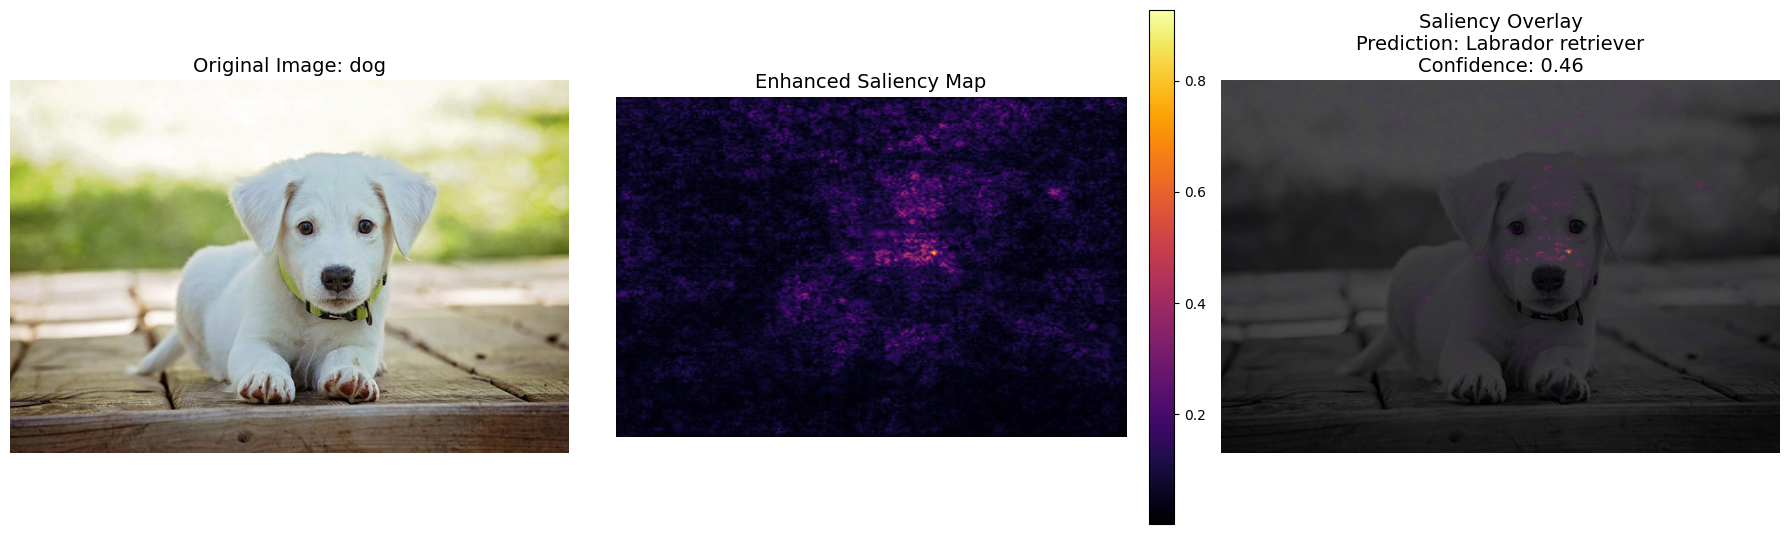

In [8]:
# Reload your original (untransformed) image for display
img_display = np.array(img_pil)

# Compute saliency map
sal_map, pred_class_index, pred_prob = compute_saliency_map(model, img_tensor)

# Show results!
visualize_saliency(
    img_display,
    sal_map,
    imagenet_class_mapping[pred_class_index],
    pred_prob,
    title=os.path.splitext(os.path.basename(img_path))[0]
)

## 4 - What is GradCAM?

### 4.1 A bit of theory

GradCAM works by combining your model's **"attention" map** (from its deepest convolutional layer) with the **gradient of the output for the target class**.  
- In other words: You see *where* the model looked when deciding "this is a cat!" or "this is a dog!".

Here's how the algorithm works, at a high-level:
1. The image is passed through the CNN; activations (feature maps) from the last convolutional layer are saved.
2. The gradient of the class score (for the class you care about) is computed with respect to these feature maps.
3. These gradients are averaged (global average pooling) to get "importance weights" for each channel.
4. The feature maps are weighted by their importance and summed.
5. The map is passed through a ReLU (so only positive influences remain).
6. The heatmap is upsampled and overlaid on the input image for interpretation.

<details>
<summary><strong>Details & Formula (click to expand)</strong></summary>

If $A^k$ is the $k$-th feature map in the last conv layer, and $y^c$ is the output for class $c$,

- Importance weight:
  $$\quad \alpha_k^c = \frac{1}{Z} \sum_i\sum_j \frac{\partial y^c}{\partial A^k_{ij}}$$
- GradCAM:
 $$\quad L^{c}_{\text{Grad-CAM}} = \mathrm{ReLU}\left(\sum_k \alpha_k^c A^k\right)$$

In [9]:
import torch
import torch.nn as nn

class GradCAM:
    """
    Minimal, robust Grad-CAM.
    - target_layer: a conv module whose activations you want (e.g., resnet.layer4[-1].conv3)
    - Call the instance with an input tensor [1,3,H,W]; optionally pass class_idx.
    - Use as a context manager to auto-remove hooks.
    """
    def __init__(self, model: nn.Module, target_layer: nn.Module):
        self.model = model
        self.target_layer = target_layer
        self.activations = None   # [N,C,H',W']
        self.gradients = None     # [N,C,H',W']
        self.target_layer.register_forward_hook(self._on_forward)

    def _on_forward(self, module, inputs, output):
        # Save activations; attach a grad hook to this tensor to capture gradients on backward
        self.activations = output.detach()
        def _on_backward(grad):
            self.gradients = grad.detach()
        output.register_hook(_on_backward)

    def __call__(self, x: torch.Tensor, class_idx: int | None = None):
        """
        Returns:
          cam_np: np.ndarray of shape [H', W'] in [0,1]
          class_idx: int used for Grad-CAM
        """
        self.model.zero_grad(set_to_none=True)
        output = self.model(x)  # logits [1, num_classes]
        if class_idx is None:
            class_idx = int(output.argmax(dim=1).item())

        # Backprop only for the chosen class (no retain_graph needed)
        score = output[:, class_idx].sum()
        score.backward()

        # weights: channel-wise mean of gradients
        # activations/gradients are [1, C, H', W']; collapse batch dimension
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)      # [1,C,1,1]
        cam = (weights * self.activations).sum(dim=1, keepdim=False) # [1,H',W']
        cam = cam.relu()[0]  # keep positive influence

        # normalize to [0,1]
        cam -= cam.min()
        cam /= cam.max().clamp_min(1e-8)
        return cam.detach().cpu().numpy(), class_idx

In [10]:
def compute_gradcam(img_path, model, transform, device):
    """
    Given an image file, compute the GradCAM heatmap for the most likely class.

    Args:
        img_path (str): Path to the input image.
        model (torch.nn.Module): Pretrained PyTorch model (e.g., ResNet50).
        transform (callable): Preprocessing function for model input.
        device (torch.device): Device to run computation on (cpu/cuda).

    Returns:
        img_display (np.ndarray): The preprocessed image for display (H, W, 3).
        heatmap (np.ndarray): The GradCAM heatmap (h', w') with values in [0, 1].
        pred_class_name (str): String with the ImageNet class label.
        pred_score (float): Class confidence/probability.
    """
    try:
        # -------- 1. Load and prepare the image --------
        img = load_image(img_path)  # Load the image, make sure it's RGB
        img_display = np.array(img.resize((224, 224)))   # Resize for consistent display (uint8)
        img_tensor = transform(img).unsqueeze(0).to(device)   # Transform: resize, normalize, (1,3,224,224)

        # -------- 2. Forward pass: Model prediction --------
        output = model(img_tensor)  # Output logits from the model
        pred_class_idx = torch.argmax(output, dim=1).item()   # Index of highest scoring class
        # Get predicted class probability (softmax output, as float)
        pred_score = torch.softmax(output, dim=1)[0, pred_class_idx].item()
        # Map class index to human-readable label
        pred_class_name = imagenet_class_mapping[pred_class_idx]

        # -------- 3. GradCAM calculation (for model explanation) --------
        # Pick the last convolutional layer in ResNet50 for GradCAM (recommended practice)
        grad_cam = GradCAM(model, model.layer4[-1].conv3)
        # Generate GradCAM heatmap for the predicted class
        heatmap, _= grad_cam(img_tensor, pred_class_idx)  # heatmap shape: (activation_h, activation_w)

        # -------- 4. Return results for visualization --------
        return img_display, heatmap, pred_class_name, pred_score

    except Exception as e:
        # Handles any error during loading or computation gracefully
        print(f"Error processing image {img_path}: {e}")
        return None, None, "Error", 0

Summary of the steps:

1. Loads and preprocesses an image for ResNet input.
2. Forwards through the model to get a class prediction, probability, and label.
3. Computes GradCAM for that class using the last convolutional layer.
4. Returns everything needed for visualization: display image, heatmap, label, and score.

In [11]:
def visualize_gradcam(img_display, heatmap, pred_class, pred_score, title):
    """
    Visualizes GradCAM results using Matplotlib.

    This function creates a figure with 3 side-by-side panels:
      1. The original image.
      2. The standalone GradCAM heatmap, showing the most important "regions" for prediction.
      3. An overlay of the heatmap on the original image, so you can see how the model's "attention"
         aligns with visual features.

    The last panel is saved as a PNG with the filename: {title}_gradcam.png

    Args:
        img_display (np.ndarray): The image to display (height x width x 3, uint8).
        heatmap (np.ndarray): The GradCAM activation map (values in [0,1]).
        pred_class (str or int): The predicted class label or index.
        pred_score (float): Model confidence/probability for predicted class.
        title (str): Output filename prefix and figure titles.
    """
    # --------- 1. Set up a 3-panel matplotlib figure ---------
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

    # --------- 2. Show original image ---------
    ax1.imshow(img_display)
    ax1.set_title(f'Original Image: {title}', fontsize=14)
    ax1.axis('off')

    # --------- 3. Show GradCAM heatmap alone ---------
    # The heatmap is already normalized to [0,1]; use 'jet' colormap for colorful regions
    ax2.imshow(heatmap, cmap='jet')
    ax2.set_title('GradCAM Heatmap', fontsize=14)
    ax2.axis('off')

    # --------- 4. Overlay heatmap on original image ---------
    # a. Resize the heatmap to match the original image size (if necessary)
    heatmap_resized = cv2.resize(heatmap, (img_display.shape[1], img_display.shape[0]))
    # b. Convert the heatmap to a color image using OpenCV's colormap
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    # c. Convert color from BGR (OpenCV default) to RGB (matplotlib expects RGB)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)
    # d. Overlay: combine original image and heatmap color with chosen transparency
    # 0.6 for original image, 0.4 for heatmap = visible blend of both
    superimposed = cv2.addWeighted(img_display, 0.6, heatmap_color, 0.4, 0)
    ax3.imshow(superimposed)
    # Show predicted class and confidence in the overlay title
    ax3.set_title(f'GradCAM Overlay\nPrediction: {pred_class}\nConfidence: {pred_score:.2f}', fontsize=14)
    ax3.axis('off')

    # --------- 5. Finalize and save ---------
    plt.tight_layout()
    plt.show()

Processing cat...


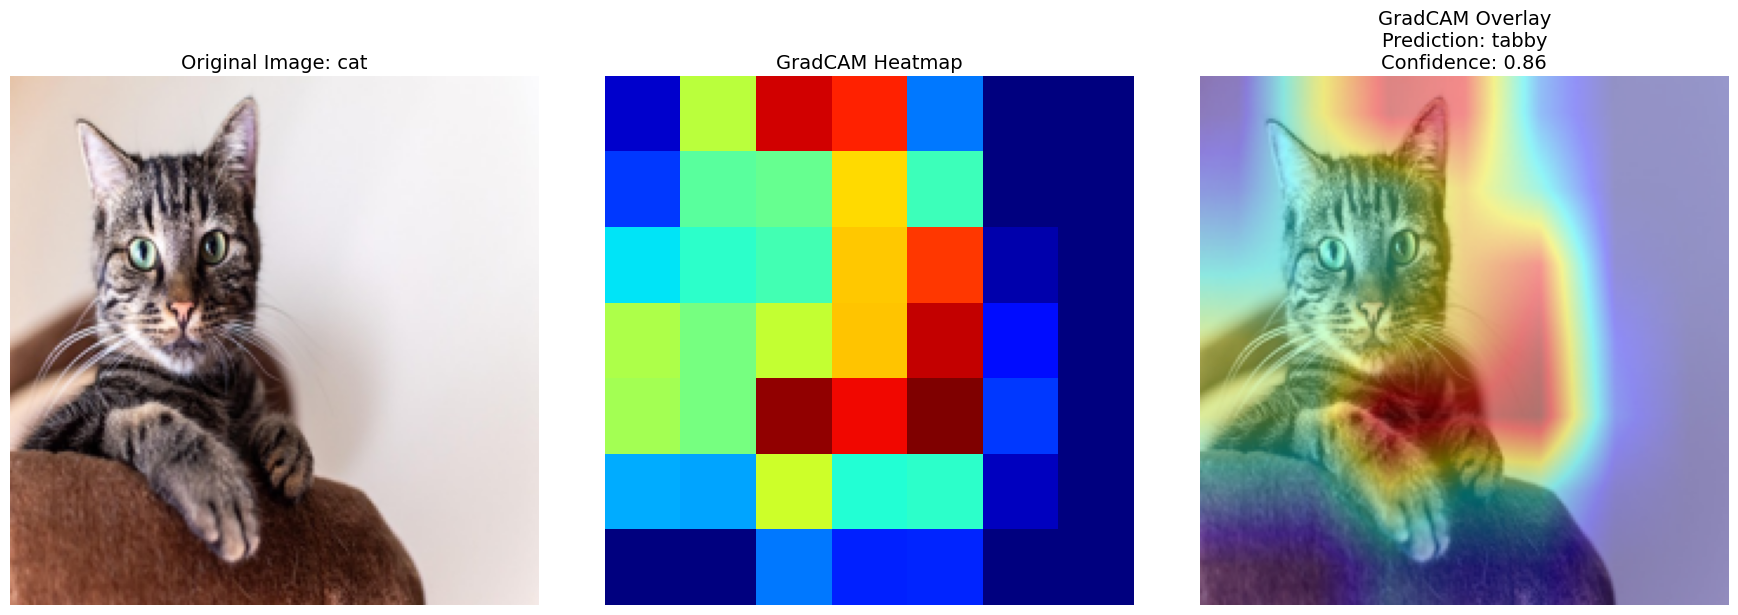

In [12]:
image_files = ['images/cat.jpg']
# Check that files exist
existing_files = [f for f in image_files if os.path.exists(f)]
for img_path in existing_files:
    # Use only base filename for saving overlays!
    title = os.path.splitext(os.path.basename(img_path))[0]
    print(f"Processing {title}...")
    img_display, heatmap, pred_class, pred_score = compute_gradcam(
        img_path, model, transform, device
    )
    if img_display is not None:
        visualize_gradcam(img_display, heatmap, pred_class, pred_score, title)
    else:
        print(f"Skipping visualization for {img_path}")

In [13]:
import helper_utils

In [14]:
helper_utils.plot_widget(compute_gradcam, visualize_gradcam, model, transform, device, folder="images")

HTML(value='<h3>GradCAM Visualizer</h3>Select an image from <code>images</code>:')

interactive(children=(Dropdown(description='Select image:', layout=Layout(width='50%'), options=('bird.jpg', '…

Output()

## 5 - Conclusion

In this lab, you explored some of the most widely-used techniques for interpreting deep convolutional neural networks: **Saliency Maps** and **Class Activation Maps (GradCAM)**.  
By visualizing model “attention” on your own images, you gained practical insights into how a state-of-the-art classifier like ResNet50 reasons about visual information.

**What you accomplished:**
- Loaded and preprocessed images for a pretrained model.
- Calculated and displayed saliency maps, highlighting pixels that most strongly influenced the model's decision for a target class.
- Used GradCAM to generate and overlay spatial heatmaps, revealing which regions of an input image drove the final prediction.
- Built reusable and interactive tools for explaining model behavior, empowering you to easily run these analyses on new images.
